In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# Load cleaned data from CSV
input_path = "world_bank_data_clean.csv"
world_bank_data = pd.read_csv(input_path)

In [3]:
# Select only numeric columns
numeric_cols = [col for col in world_bank_data.columns 
               if col not in ['country', 'date', 'year']]

# Compute summary statistics (mean, median, max, variance)
aggregations = {col: ['mean', 'median', 'max', 'var'] for col in numeric_cols}
world_bank_data_agg = world_bank_data.groupby("country")[numeric_cols].agg(aggregations)

# Flatten multiIndex column names
world_bank_data_agg.columns = ["_".join(map(str, col)) for col in world_bank_data_agg.columns]
world_bank_data_agg.reset_index(inplace=True)

# Drop country column
X = world_bank_data_agg.drop(columns=['country'])

In [4]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# DataLoader
X = torch.as_tensor(X_scaled, dtype=torch.float32)
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# Autoencoder
class AE(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, input_dim),
            nn.Identity()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AE(input_dim=X.shape[1]).to(device)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-8)

In [7]:
# Training loop
epochs = 200
losses = []
epoch_losses = []

for epoch in range(epochs):
    model.train()
    running = 0.0

    for (xb,) in loader:
        xb = xb.to(device)

        x_hat, z = model(xb)
        loss = loss_function(x_hat, xb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        running += loss.item() * xb.size(0)

    epoch_loss = running / len(dataset)
    epoch_losses.append(epoch_loss)

    if (epoch + 1) % 25 == 0 or (epoch + 1) == 1 or (epoch + 1) == epochs:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.6f}")

Epoch 1/200, Loss: 1.008397
Epoch 25/200, Loss: 0.483631
Epoch 50/200, Loss: 0.366064
Epoch 75/200, Loss: 0.303444
Epoch 100/200, Loss: 0.266386
Epoch 125/200, Loss: 0.235466
Epoch 150/200, Loss: 0.210534
Epoch 175/200, Loss: 0.191040
Epoch 200/200, Loss: 0.177150


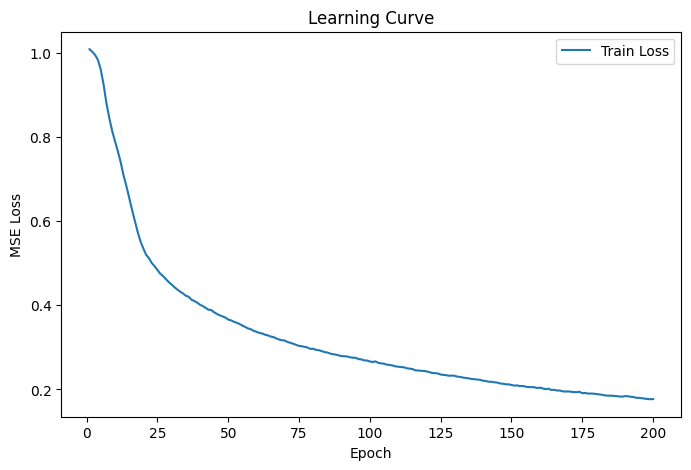

In [9]:
# Learning curve (loss vs epoch)
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Learning Curve")
plt.legend()
plt.show()

In [10]:
# Infer the latent space
model.encoder.eval()
with torch.no_grad():
    Z = model.encoder(X.to(device)).cpu().numpy()

print(Z.shape)

(219, 8)


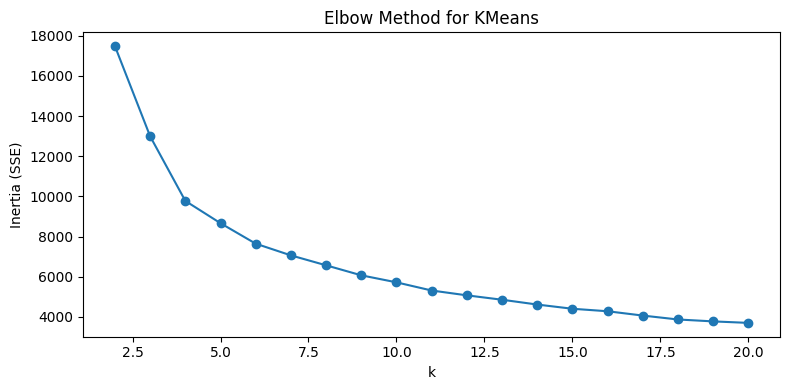

In [11]:
# Fit KMeans for different k values and record inertia (SSE) to use the elbow method.
ks = range(2, 21)        # Different values of k (number of clusters)
inertias = []

for k in ks:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(Z)
    inertias.append(km.inertia_)

# Elbow plot
plt.figure(figsize=(8, 4))
plt.plot(list(ks), inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for KMeans")
plt.tight_layout()
plt.show()

In [12]:
# Fit KMeans with best k
best_k = 4

kmeans = KMeans(n_clusters=best_k, n_init=100, random_state=42)
labels = kmeans.fit_predict(Z)

print("cluster counts:", np.bincount(labels))

cluster counts: [134   3  51  31]


In [13]:
# Metrics for the fitted clustering
sil = silhouette_score(Z, labels)          # higher is better
db  = davies_bouldin_score(Z, labels)      # lower is better
ch  = calinski_harabasz_score(Z, labels)   # higher is better

print(f"Silhouette: {sil:.4f}")
print(f"Davies-Bouldin: {db:.4f}")
print(f"Calinski-Harabasz: {ch:.2f}")

Silhouette: 0.4373
Davies-Bouldin: 0.8977
Calinski-Harabasz: 138.37


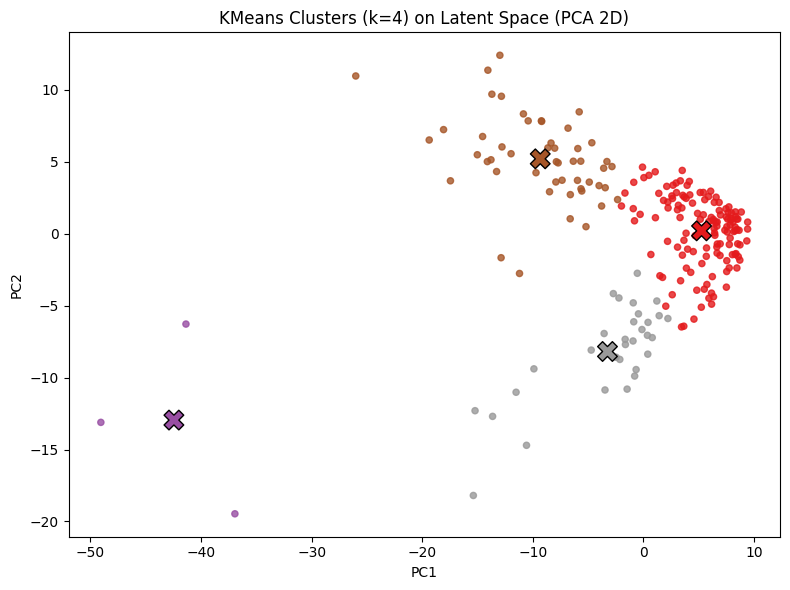

In [14]:
# Reduce latent space to 2D for visualization
Z_2d = PCA(n_components=2, random_state=42).fit_transform(Z)
centers_2d = PCA(n_components=2, random_state=42).fit(Z).transform(kmeans.cluster_centers_)

# Plot the Clusters
plt.figure(figsize=(8, 6))
plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=labels, s=20, alpha=0.8, cmap='Set1')
plt.scatter(centers_2d[:, 0], centers_2d[:, 1],
            c=np.arange(best_k), cmap=plt.gca().collections[0].cmap,
            s=200, marker="X", edgecolors="k")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"KMeans Clusters (k={best_k}) on Latent Space (PCA 2D)")
plt.tight_layout()
plt.show()

In [15]:
# Examine clusters
country_col = "country"
n_show = 20

df_clusters = world_bank_data_agg.copy()
df_clusters["cluster"] = labels

cols = {}
for c in sorted(df_clusters["cluster"].unique()):
    s = df_clusters.loc[df_clusters["cluster"] == c, country_col]
    s = s.sample(n=min(n_show, len(s)), random_state=42, replace=False).tolist()
    cols[f"Cluster {c}"] = s

max_len = max(len(v) for v in cols.values())
for k in cols:
    cols[k] += [np.nan] * (max_len - len(cols[k]))

wide = pd.DataFrame(cols)
print(wide.to_string(index=False))

          Cluster 0          Cluster 1        Cluster 2                 Cluster 3
         Uzbekistan              China      South Sudan                     Spain
             Latvia              India     Sierra Leone                    Kosovo
    Slovak Republic Sub-Saharan Africa      Timor-Leste                   Romania
             Brazil                NaN Congo, Dem. Rep. Latin America & Caribbean
            Georgia                NaN          Lesotho                   Germany
              Kenya                NaN          Namibia                     Ghana
           Barbados                NaN         Eswatini            United Kingdom
          St. Lucia                NaN            Nauru              Saudi Arabia
              Samoa                NaN            Benin                   Ireland
         San Marino                NaN       Mozambique                   Bahrain
             Greece                NaN      Congo, Rep.            Cayman Islands
               F